<a href="https://colab.research.google.com/github/arginoa/ai4all-medicalai/blob/main/SttrikeNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Libraries
!pip install optuna
!pip install efficientnet_pytorch

import optuna
from optuna import Trial, visualization
from optuna.trial import TrialState
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
from PIL import Image
import random
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-many

In [2]:
# Import drives

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Custom Dataset
class APTOSDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        try:
            img_name = os.path.join(self.root_dir, 'train_images', self.data_frame.iloc[idx, 0] + '.png')
            image = Image.open(img_name).convert('RGB')
            label = int(self.data_frame.iloc[idx, 1])
            if self.transform:
                image = self.transform(image=np.array(image))['image']
        except:
            return self.__getitem__(random.randint(0, self.__len__() - 1))
        return image, label

In [4]:
# Access Drive
data_path = '/content/drive/My Drive/aptos2019-blindness-detection'
csv_file = os.path.join(data_path, 'train.csv')

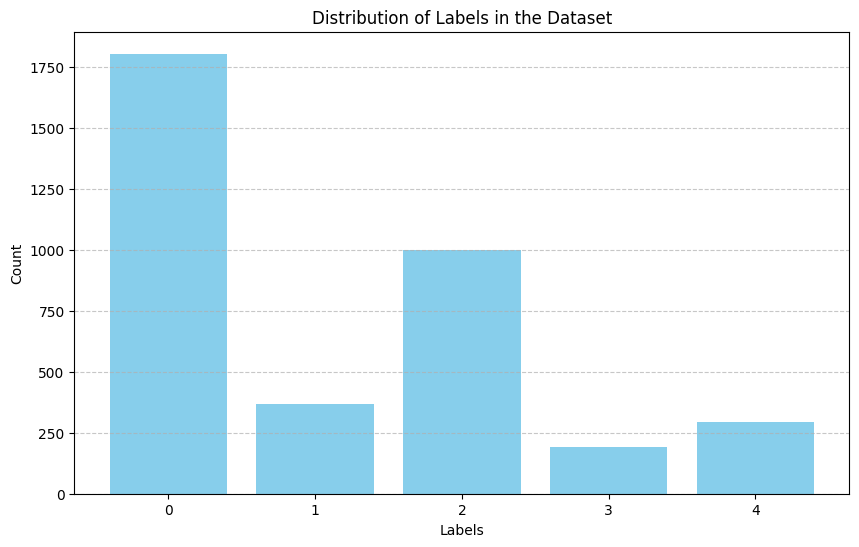

In [5]:
data_frame = pd.read_csv(csv_file)

# Count the occurrences of each label
label_counts = data_frame.iloc[:, 1].value_counts().sort_index()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels in the Dataset')
plt.xticks(range(5), ['0', '1', '2', '3', '4'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [6]:
# Augmentations
transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0, scale_limit=0.0, rotate_limit=10, p=0.5),  # Random rotation up to 10 degrees
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),  # Adjust brightness and contrast within [0.9, 1.1]
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [7]:
# Dataset Initialization


full_dataset = APTOSDataset(csv_file=csv_file, root_dir=data_path, transform=transform)
train_size = int(0.8 * len(full_dataset))  # 80% Train
val_size = int(0.1 * len(full_dataset))  # 10% Val
test_size = len(full_dataset) - train_size - val_size  # 10% Test

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

In [13]:
# Define CustomModel (Efficient Net)

from efficientnet_pytorch import EfficientNet

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b7')
        self.efficientnet._fc = nn.Identity()
        self.fc1 = nn.Linear(2560, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 5)

    def forward(self, x):
        x = self.efficientnet(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [14]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

In [15]:
# Device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
def compute_metrics(outputs, labels):
    _, preds = torch.max(outputs, 1)
    accuracy = accuracy_score(labels.cpu(), preds.cpu())
    auroc = roc_auc_score(labels.cpu(), torch.softmax(outputs, dim=1).cpu(), multi_class='ovr')
    f1 = f1_score(labels.cpu(), preds.cpu(), average='macro')
    return accuracy, auroc, f1

def train_and_evaluate(model, criterion, optimizer, scheduler, num_epochs, train_loader, val_loader):
    # Initialize tracking variables
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_aurocs = []
    val_aurocs = []
    train_f1s = []
    val_f1s = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels = []
        all_outputs = []
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                all_labels.append(labels.detach())
                all_outputs.append(outputs.detach())
                pbar.set_postfix(loss=running_loss / (i + 1))
                pbar.update(1)

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_labels = torch.cat(all_labels)
        train_outputs = torch.cat(all_outputs)
        train_accuracy, train_auroc, train_f1 = compute_metrics(train_outputs, train_labels)
        train_accuracies.append(train_accuracy)
        train_aurocs.append(train_auroc)
        train_f1s.append(train_f1)

        model.eval()
        val_loss = 0.0
        all_labels = []
        all_outputs = []
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                all_labels.append(labels)
                all_outputs.append(outputs)

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_labels = torch.cat(all_labels)
        val_outputs = torch.cat(all_outputs)
        val_accuracy, val_auroc, val_f1 = compute_metrics(val_outputs, val_labels)
        val_accuracies.append(val_accuracy)
        val_aurocs.append(val_auroc)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch + 1}:")
        print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, AUROC: {train_auroc:.4f}, F1 Score: {train_f1:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, AUROC: {val_auroc:.4f}, F1 Score: {val_f1:.4f}")

    return model, train_losses, val_losses, train_accuracies, val_accuracies, train_aurocs, val_aurocs, train_f1s, val_f1s


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:04<00:00, 53.9MB/s]


Loaded pretrained weights for efficientnet-b7


Epoch 1/3: 100%|██████████| 184/184 [17:05<00:00,  5.58s/batch, loss=0.529]


Epoch 1:
  Train Loss: 0.5291, Accuracy: 0.6784, AUROC: 0.8125, F1 Score: 0.3577
  Val Loss: 0.3565, Accuracy: 0.7650, AUROC: 0.9056, F1 Score: 0.4583


Epoch 2/3: 100%|██████████| 184/184 [06:06<00:00,  1.99s/batch, loss=0.345]


Epoch 2:
  Train Loss: 0.3450, Accuracy: 0.7542, AUROC: 0.8970, F1 Score: 0.5242
  Val Loss: 0.2390, Accuracy: 0.8251, AUROC: 0.9219, F1 Score: 0.5813


Epoch 3/3: 100%|██████████| 184/184 [06:06<00:00,  1.99s/batch, loss=0.29]


Epoch 3:
  Train Loss: 0.2898, Accuracy: 0.7928, AUROC: 0.9215, F1 Score: 0.5931
  Val Loss: 0.2405, Accuracy: 0.8060, AUROC: 0.9274, F1 Score: 0.5757


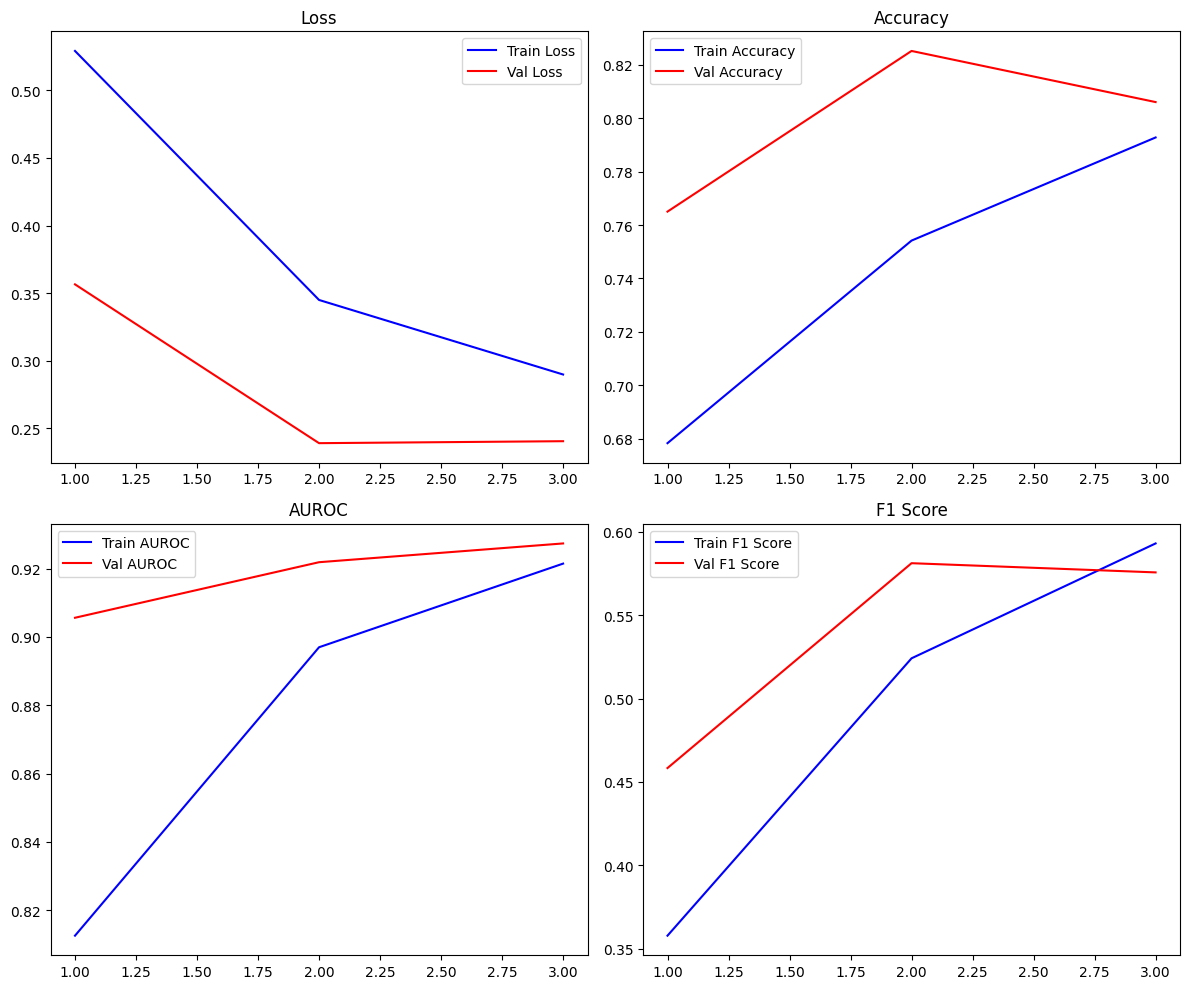

Evaluating: 100%|██████████| 23/23 [02:00<00:00,  5.26s/batch]


Test Loss: 0.2990
Test Accuracy: 0.7602
Test AUROC: 0.9144
Test F1 Score: 0.5472


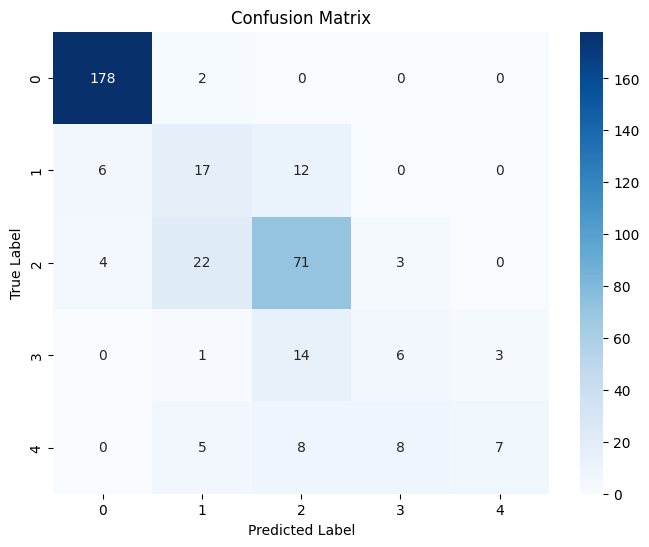

In [17]:
# Number of epochs for final training
final_num_epochs = 3

# Train with the best hyperparameters
best_lr = 1e-4
best_model = CustomModel().to(device)
criterion = FocalLoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

best_model, train_losses, val_losses, train_accuracies, val_accuracies, train_aurocs, val_aurocs, train_f1s, val_f1s = train_and_evaluate(
    best_model, criterion, optimizer, scheduler, final_num_epochs, train_loader, val_loader)

torch.save(best_model.state_dict(), 'best_diabetic_retinopathy_resnet50_model.pth')

# Plot metrics
epochs = range(1, final_num_epochs + 1)
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, val_losses, 'r', label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, train_aurocs, 'b', label='Train AUROC')
plt.plot(epochs, val_aurocs, 'r', label='Val AUROC')
plt.title('AUROC')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, train_f1s, 'b', label='Train F1 Score')
plt.plot(epochs, val_f1s, 'r', label='Val F1 Score')
plt.title('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluate on the test set
best_model.eval()
test_loss = 0.0
all_labels = []
all_outputs = []
with torch.no_grad():
    with tqdm(total=len(test_loader), desc="Evaluating", unit="batch") as pbar:
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = best_model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            all_labels.append(labels)
            all_outputs.append(outputs)
            pbar.update(1)

test_loss /= len(test_loader)
test_labels = torch.cat(all_labels)
test_outputs = torch.cat(all_outputs)
test_accuracy, test_auroc, test_f1 = compute_metrics(test_outputs, test_labels)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUROC: {test_auroc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(test_labels.cpu(), torch.argmax(test_outputs, 1).cpu())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
